In [1]:
import random
from numpy.random import seed
seed(3)
import numpy as np
np.random.default_rng
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandas import read_csv
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from os.path import expanduser as ospath
import time

import xgboost as xgb
from sklearn.model_selection import KFold,GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
import gensim

# 1. Load data set with cleaned text

In [2]:
with open(ospath('~/final_project/B_Data_pre_processing/Pickle_Files/Claims_cleaned.pickle'), 'rb') as data:
    db = pickle.load(data)

In [3]:
db.head()

,publn_nr,type,label,text,text_clean
1,4254843,Claim 1,product,An electrically powered vehicle comprising: a ...,electrically power vehicle comprise body suppo...
2,4254843,Claim 2,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim wherei...
3,4254843,Claim 3,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim wherei...
4,4254843,Claim 4,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim compri...
5,4254843,Claim 5,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim compri...


In [4]:
db.groupby(by='label').count()

,publn_nr,type,text,text_clean
label,,,,
process,740,740,740,740
product,3809,3809,3809,3809
product and process,1,1,1,1
use claim,307,307,307,307


This convert name labels from string to numbers and merge them into only two classes 

In [5]:
db['label'] = db.label.replace(to_replace=['product', 'process', 'use claim', 'product and process'], value=[1, 0, 0,1])
db.groupby(by='label').count()

,publn_nr,type,text,text_clean
label,,,,
0,1047,1047,1047,1047
1,3810,3810,3810,3810


## 2. Split the dataset by patents into train, validation and test datasets 


In [6]:
def split_train_test_val(db):
    
    random.seed(4)
    pat_nr = list(db['publn_nr'].unique())
    print('number of patents :',str(len(pat_nr )))

    test =  random.sample(pat_nr, 48)

    train_test = [i for i in pat_nr if i not in test]

    val = random.sample(train_test, 48)

    train = [i for i in train_test if i not in val]

    #create an empty data set
    train_db = pd.DataFrame()                             
    for num in range(len(train)):   
        train_db = train_db.append(db.loc[db['publn_nr'] == train[num]], ignore_index=True)

    #create an empty data set
    val_db = pd.DataFrame()                             
    for num in range(len(val)):   
        val_db = val_db.append(db.loc[db['publn_nr'] == val[num]], ignore_index=True)

    #create an empty data set
    test_db = pd.DataFrame()                             
    for num in range(len(test)):   
        test_db = test_db.append(db.loc[db['publn_nr'] == test[num]], ignore_index=True)

    print('-'*80,'\n')
    print('Train data:')
    print('Train data shape: {} \nNumber of patents: {}'.format(train_db.shape ,len(train_db['publn_nr'].unique())))
    print('First patent number train:',train_db['publn_nr'].iloc[0])
    print()
    print('Train frequency classes:',train_db.groupby(by='label').count().iloc[:,:1])
    print('-'*80,'\n')
    print('Test data:')
    print('Test data shape: {} \nNumber of patents: {}'.format(test_db.shape, len(test_db['publn_nr'].unique())))
    print('First patent number test:',test_db['publn_nr'].iloc[0])
    print()
    print('Test frequency classes:',test_db.groupby(by='label').count().iloc[:,:1])
    print('-'*80,'\n')
    print('Val data:')
    print('Val data shape: {} \nNumber of patents: {}'.format(val_db.shape, len(val_db['publn_nr'].unique())))
    print('First patent number val:',val_db['publn_nr'].iloc[0])
    print()
    print('Val frequency classes:',val_db.groupby(by='label').count().iloc[:,:1],'\n')
    
    
    return train_db, test_db, val_db

train_db, test_db, val_db = split_train_test_val(db)

number of patents : 194
-------------------------------------------------------------------------------- 

Train data:
Train data shape: (2550, 5) 
Number of patents: 98
First patent number train: 4254843

Train frequency classes:        publn_nr
label          
0           485
1          2065
-------------------------------------------------------------------------------- 

Test data:
Test data shape: (1285, 5) 
Number of patents: 48
First patent number test: 6700383

Test frequency classes:        publn_nr
label          
0           313
1           972
-------------------------------------------------------------------------------- 

Val data:
Val data shape: (1022, 5) 
Number of patents: 48
First patent number val: 7189771

Val frequency classes:        publn_nr
label          
0           249
1           773 



### Separate for the three datasets the features from the labels

In [7]:
X_train = train_db['text_clean']
y_train = train_db['label']

X_val = val_db['text_clean']
y_val = val_db['label']

X_test = test_db['text_clean']
y_test = test_db['label']

y_train = y_train.astype('int')
y_val = y_val.astype('int')
y_test = y_test.astype('int')

## 3. Load the Word2Vec model

In [8]:
model_w2v = gensim.models.Word2Vec.load(ospath('~/final_project/C_Feature_extraction/model_w2v_300_uspto_epo'))

In order to use a word2vec model trained on another text, we need to transform all the words in the new text 
in vectors and this can be done by averanging the word vectors of the word2vec model for all the words in the new text.

In [9]:
class MeanEmbeddingVectorizer(object):
    
    """This class builds the feature
    by averanging the word vectors
    for the words in the text"""
    
    def __init__(self, word2vec, dim):
        self.word2vec = word2vec
        self.dim = dim

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
# reference http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

We create the new dictionary of vectors

In [10]:
w2v = {w: vec for w, vec in zip(model_w2v.wv.index2word, model_w2v.wv.syn0)}

## 4. Test harness to spot-check the best algorithms

In [11]:

#pipelines of the models with different vectorization methods
logi_model_tfidf = Pipeline([("tfidf", TfidfVectorizer(lowercase=False,ngram_range=(1,2), max_features=300,sublinear_tf=True)),  ('LOGI', LogisticRegression(random_state = 0, n_jobs=-1))])
logi_model_w2v = Pipeline([("word2vec",MeanEmbeddingVectorizer(w2v, 300)) , ('LOGI', LogisticRegression(random_state = 0,n_jobs=-1))])

xgb_model_tfidf = Pipeline([("tfidf", TfidfVectorizer(lowercase=False,ngram_range=(1,2), max_features=300,sublinear_tf=True)),  ('XGB', xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1))])
xgb_model_w2v = Pipeline([("word2vec",MeanEmbeddingVectorizer(w2v,300)) , ('XGB', xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1))])

SVM_model_tfidf = Pipeline([("tfidf", TfidfVectorizer(lowercase=False,ngram_range=(1,2), max_features=300,sublinear_tf=True)) , ('SVM', SVC(random_state = 0))])
SVM_model_w2v = Pipeline([("word2vec",MeanEmbeddingVectorizer(w2v, 300)) , ('SVM', SVC(random_state = 0))])

RFC_model_tfidf = Pipeline([("tfidf", TfidfVectorizer(lowercase=False,ngram_range=(1,2), max_features=300,sublinear_tf=True)),('RFC', RandomForestClassifier(n_jobs=-1))])
RFC_model_w2v = Pipeline([("word2vec",MeanEmbeddingVectorizer(w2v, 300)),('RFC', RandomForestClassifier(random_state = 0, n_jobs=-1))])

models = []
models.append(('LOGI_tfidf', logi_model_tfidf))
models.append(('LOGI_w2v', logi_model_w2v))
models.append(('XGB_tfidf', xgb_model_tfidf))
models.append(('xgb__w2v', xgb_model_w2v))
models.append(('SVM_tfidf', SVM_model_tfidf))
models.append(('SVM_w2v', SVM_model_w2v))
models.append(('RFC_tfidf', RFC_model_tfidf))
models.append(('RFC_w2v', RFC_model_w2v))

#for the parameters scoring 
scoring_acc = metrics.make_scorer(metrics.accuracy_score)
scoring_prec = metrics.make_scorer(metrics.precision_score)
scoring_rec = metrics.make_scorer(metrics.recall_score)
scoring_f1 = metrics.make_scorer(metrics.f1_score)

score_list = []
score_list.append(scoring_acc)
score_list.append(scoring_prec)
score_list.append(scoring_rec)
score_list.append(scoring_f1)

names_score = ['acc', 'prec', 'rec', 'f1']
name_score_model = []

#to store results of cv in a data set
results_std = []
results_mean = []
results = []

#
time_models =[]

for name, model in models:
    for score, name_score in zip(score_list, names_score):
        kfold = KFold(n_splits=10, random_state=7)
        
        #timing the model
        start = time.time()
        results_cv = cross_val_score(model, X_train, y_train, cv=kfold, scoring= score)
        end = time.time()
        
        results_mean.append(round(results_cv.mean(),5))
        results_std.append(round(results_cv.std(),5))
        results.append(results_cv)
        time_models.append(round(end - start, 5))
        name_score_model.append((name, name_score))
        
name_dict_db_results = [' '.join(map(str,name_score_model[i])) for i in range(len(name_score_model))]
dictionary_results = {'Model': name_dict_db_results, 'Mean': results_mean, 'Std': results_std, 'time_models' :time_models } 
db_results = pd.DataFrame(dictionary_results)

#Adapted from - Brownlee, J. (2016) Machine learning mastery with Python: understand your data, create accurate models, and work projects end-to-end.

In [12]:
db_results

,Model,Mean,Std,time_models
0,LOGI_tfidf acc,0.93961,0.04949,5.33605
1,LOGI_tfidf prec,0.92522,0.08515,1.90590
2,LOGI_tfidf rec,0.99600,0.00768,1.29353
3,LOGI_tfidf f1,0.95701,0.05150,1.22522
4,LOGI_w2v acc,0.80980,0.15693,77.10259
5,LOGI_w2v prec,0.80980,0.15693,81.00787
6,LOGI_w2v rec,1.00000,0.00000,84.68532
7,LOGI_w2v f1,0.88499,0.11496,85.58378
8,XGB_tfidf acc,0.98235,0.01610,5.51802
9,XGB_tfidf prec,0.98640,0.02073,4.54485


### The best two perfomance is achieved by XGBoost and Random Forest with TF-IDF vectorizer
The word2vec, even though achieving a good performance, was not able to reach the same levels as with the TF-IDF vectorizer. 

In [13]:
ls = [8,9,10,11,24,25,26,27]
values = pd.DataFrame()
res = []
for i in ls:
    da = db_results.loc[i]
    values = values.append(da)
    da = results[i]
    res.append(da)
values = values.reset_index(drop=True)
print(values)

      Mean           Model      Std  time_models
0  0.98235   XGB_tfidf acc  0.01610      5.51802
1  0.98640  XGB_tfidf prec  0.02073      4.54485
2  0.98994   XGB_tfidf rec  0.01307      4.74032
3  0.98797    XGB_tfidf f1  0.01095      4.63860
4  0.97608   RFC_tfidf acc  0.02685      6.19257
5  0.98068  RFC_tfidf prec  0.03645      4.44938
6  0.99160   RFC_tfidf rec  0.01183      4.36439
7  0.98849    RFC_tfidf f1  0.01013      4.20141


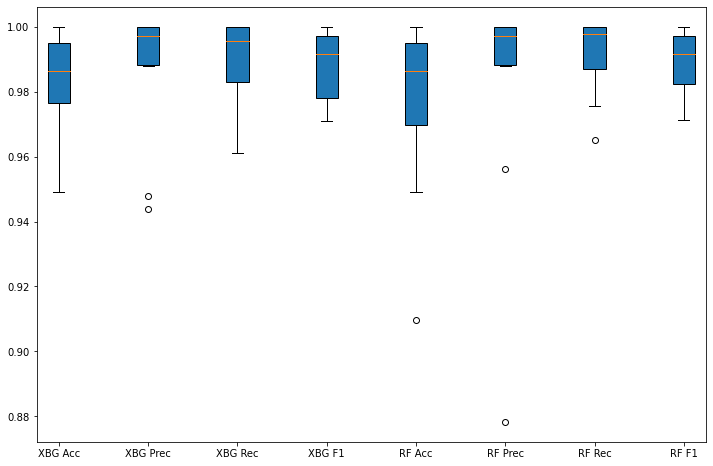

In [14]:
from matplotlib import pyplot
plt.figure(figsize=(12, 8))
box = plt.boxplot(res,patch_artist=True,
                  positions=[1,3,5,7,9,11,13,15],
                  labels=['XBG Acc','XBG Prec','XBG Rec' ,'XBG F1', 'RF Acc','RF Prec', 'RF Rec', 'RF F1'])

I will print the results achieved for the same models uisng Word2Vec - **Random Forest** and **XGBoost models**.  

In [15]:
#Word2Vec for Random Forest and XGBoost models
ls_w2v = [12,13,14,15,28,28,30,31]
values_w2v = pd.DataFrame()
res_w2v = []
for i in ls_w2v:
    da = db_results.loc[i]
    values_w2v = values_w2v.append(da)
    da = results[i]
    res_w2v.append(da)
values_w2v = values_w2v.reset_index(drop=True)
print(values_w2v)

      Mean          Model      Std  time_models
0  0.80784   xgb__w2v acc  0.09987    104.72808
1  0.82862  xgb__w2v prec  0.13682    102.12625
2  0.95576   xgb__w2v rec  0.03003    106.63782
3  0.87956    xgb__w2v f1  0.08942    102.72419
4  0.81647    RFC_w2v acc  0.11202     93.37296
5  0.81647    RFC_w2v acc  0.11202     93.37296
6  0.97033    RFC_w2v rec  0.02383     92.88750
7  0.88496     RFC_w2v f1  0.09542     89.06472


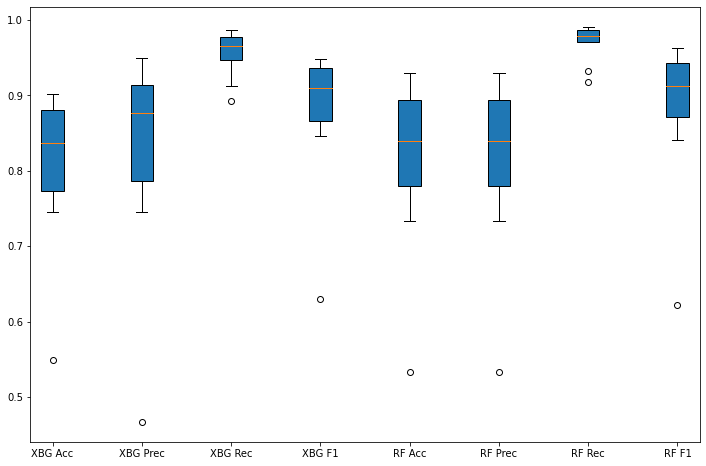

In [16]:
from matplotlib import pyplot
plt.figure(figsize=(12, 8))
box = plt.boxplot(res_w2v,patch_artist=True,
                  positions=[1,3,5,7,9,11,13,15],
                  labels=['XBG Acc','XBG Prec','XBG Rec' ,'XBG F1', 'RF Acc','RF Prec', 'RF Rec', 'RF F1'])